# Customer Churn Analysis and Classification Modeling

## Goals
My goal for this project is to construct a classification model that accurately predicts customer churn. At the same time, I would like to idendity which of these conditions and attributes are the biggest dirivers for customer churn. I will deliver the following: acquire.py, prepare.py, report.ipynb, and predictions.csv.

## Measure of success
- Find the top 5 drivers for customer churn at Telco
- A robust and general classification model

## Prepare Environment

In [1]:
# General libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Statistics library
from scipy import stats

# Machine learning libraries
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

# Self-defined helper functions
import acquire, prepare

# Ignore warning
import warnings
warnings.filterwarnings("ignore")

# Save and load machine learning models
import pickle, joblib

In [2]:
# Set plotting paras
plt.style.use('seaborn-talk')

## Data Acquisition

In [3]:
# Load dataset into pandas dataframe

df = acquire.get_telco_churn_data()
print("Number of (rows, columns): ", df.shape)
df.head()

Number of (rows, columns):  (7043, 24)


,payment_type_id,internet_service_type_id,contract_type_id,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,...,tech_support,streaming_tv,streaming_movies,paperless_billing,monthly_charges,total_charges,churn,contract_type,internet_service_type,payment_type
0,2,1,1,0003-MKNFE,Male,0,No,No,9,Yes,...,No,No,Yes,No,59.9,542.4,No,Month-to-month,DSL,Mailed check
1,4,1,1,0013-MHZWF,Female,0,No,Yes,9,Yes,...,Yes,Yes,Yes,Yes,69.4,571.45,No,Month-to-month,DSL,Credit card (automatic)
2,1,1,1,0015-UOCOJ,Female,1,No,No,7,Yes,...,No,No,No,Yes,48.2,340.35,No,Month-to-month,DSL,Electronic check
3,1,1,1,0023-HGHWL,Male,1,No,No,1,No,...,No,No,No,Yes,25.1,25.1,Yes,Month-to-month,DSL,Electronic check
4,3,1,1,0032-PGELS,Female,0,Yes,Yes,1,No,...,No,No,No,No,30.5,30.5,Yes,Month-to-month,DSL,Bank transfer (automatic)


## Data Preparation

### Summarize Data

In [4]:
# Print the concise summary of the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 24 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   payment_type_id           7043 non-null   int64  
 1   internet_service_type_id  7043 non-null   int64  
 2   contract_type_id          7043 non-null   int64  
 3   customer_id               7043 non-null   object 
 4   gender                    7043 non-null   object 
 5   senior_citizen            7043 non-null   int64  
 6   partner                   7043 non-null   object 
 7   dependents                7043 non-null   object 
 8   tenure                    7043 non-null   int64  
 9   phone_service             7043 non-null   object 
 10  multiple_lines            7043 non-null   object 
 11  online_security           7043 non-null   object 
 12  online_backup             7043 non-null   object 
 13  device_protection         7043 non-null   object 
 14  tech_sup

**Takeaways**
- The `total_charges` needs to be casted to numeric. 

In [5]:
# Replace the white space with 0 in column total_charges
df['total_charges'] = df.total_charges.apply(lambda i: "0" if i == " " else i)

In [6]:
# Correct the data types of column total_charges 

datatype = {'total_charges': 'float64'}
df = df.astype(dtype=datatype)

df.dtypes

payment_type_id               int64
internet_service_type_id      int64
contract_type_id              int64
customer_id                  object
gender                       object
senior_citizen                int64
partner                      object
dependents                   object
tenure                        int64
phone_service                object
multiple_lines               object
online_security              object
online_backup                object
device_protection            object
tech_support                 object
streaming_tv                 object
streaming_movies             object
paperless_billing            object
monthly_charges             float64
total_charges               float64
churn                        object
contract_type                object
internet_service_type        object
payment_type                 object
dtype: object

In [7]:
# Compute the number of missing valeus in each column
df.isnull().sum()

payment_type_id             0
internet_service_type_id    0
contract_type_id            0
customer_id                 0
gender                      0
senior_citizen              0
partner                     0
dependents                  0
tenure                      0
phone_service               0
multiple_lines              0
online_security             0
online_backup               0
device_protection           0
tech_support                0
streaming_tv                0
streaming_movies            0
paperless_billing           0
monthly_charges             0
total_charges               0
churn                       0
contract_type               0
internet_service_type       0
payment_type                0
dtype: int64

**Takeaways**
- No missing values have been found. 

In [8]:
# Compute the number of duplicates
df.duplicated().sum()

0

**Takeaways**
- No duplicates has been found.

In [9]:
# Count distinct observations in each column
df.nunique()

payment_type_id                4
internet_service_type_id       3
contract_type_id               3
customer_id                 7043
gender                         2
senior_citizen                 2
partner                        2
dependents                     2
tenure                        73
phone_service                  2
multiple_lines                 3
online_security                3
online_backup                  3
device_protection              3
tech_support                   3
streaming_tv                   3
streaming_movies               3
paperless_billing              2
monthly_charges             1585
total_charges               6531
churn                          2
contract_type                  3
internet_service_type          3
payment_type                   4
dtype: int64

**Takeaways**
- Columns tenure, montyly_charges and total_charges may contain quantitative/numeric values. 
- Other columns may contain qualitative/categorical values. 

In [10]:
# Compute descriptive statistics of the numeric columns in the dataframe
df.describe().T

,count,mean,std,min,25%,50%,75%,max
payment_type_id,7043.0,2.315633,1.148907,1.00,1.00,2.00,3.00,4.00
internet_service_type_id,7043.0,1.872923,0.737796,1.00,1.00,2.00,2.00,3.00
contract_type_id,7043.0,1.690473,0.833755,1.00,1.00,1.00,2.00,3.00
senior_citizen,7043.0,0.162147,0.368612,0.00,0.00,0.00,0.00,1.00
tenure,7043.0,32.371149,24.559481,0.00,9.00,29.00,55.00,72.00
monthly_charges,7043.0,64.761692,30.090047,18.25,35.50,70.35,89.85,118.75
total_charges,7043.0,2279.734304,2266.794470,0.00,398.55,1394.55,3786.60,8684.80


### Plot Distribution of Individual Variables

In [11]:
# Obtain the name of the variables

variables = df.columns
print(len(variables))
print(type(variables))
variables

24
<class 'pandas.core.indexes.base.Index'>


Index(['payment_type_id', 'internet_service_type_id', 'contract_type_id',
       'customer_id', 'gender', 'senior_citizen', 'partner', 'dependents',
       'tenure', 'phone_service', 'multiple_lines', 'online_security',
       'online_backup', 'device_protection', 'tech_support', 'streaming_tv',
       'streaming_movies', 'paperless_billing', 'monthly_charges',
       'total_charges', 'churn', 'contract_type', 'internet_service_type',
       'payment_type'],
      dtype='object')

In [12]:
# Obtain the name of the object columns

mask = (df.dtypes == 'object')
obj_cols = variables[mask].to_list()

# Mannully correct the list
obj_cols.remove('customer_id')
obj_cols.append('senior_citizen')

print(len(obj_cols))
obj_cols

17


['gender',
 'partner',
 'dependents',
 'phone_service',
 'multiple_lines',
 'online_security',
 'online_backup',
 'device_protection',
 'tech_support',
 'streaming_tv',
 'streaming_movies',
 'paperless_billing',
 'churn',
 'contract_type',
 'internet_service_type',
 'payment_type',
 'senior_citizen']

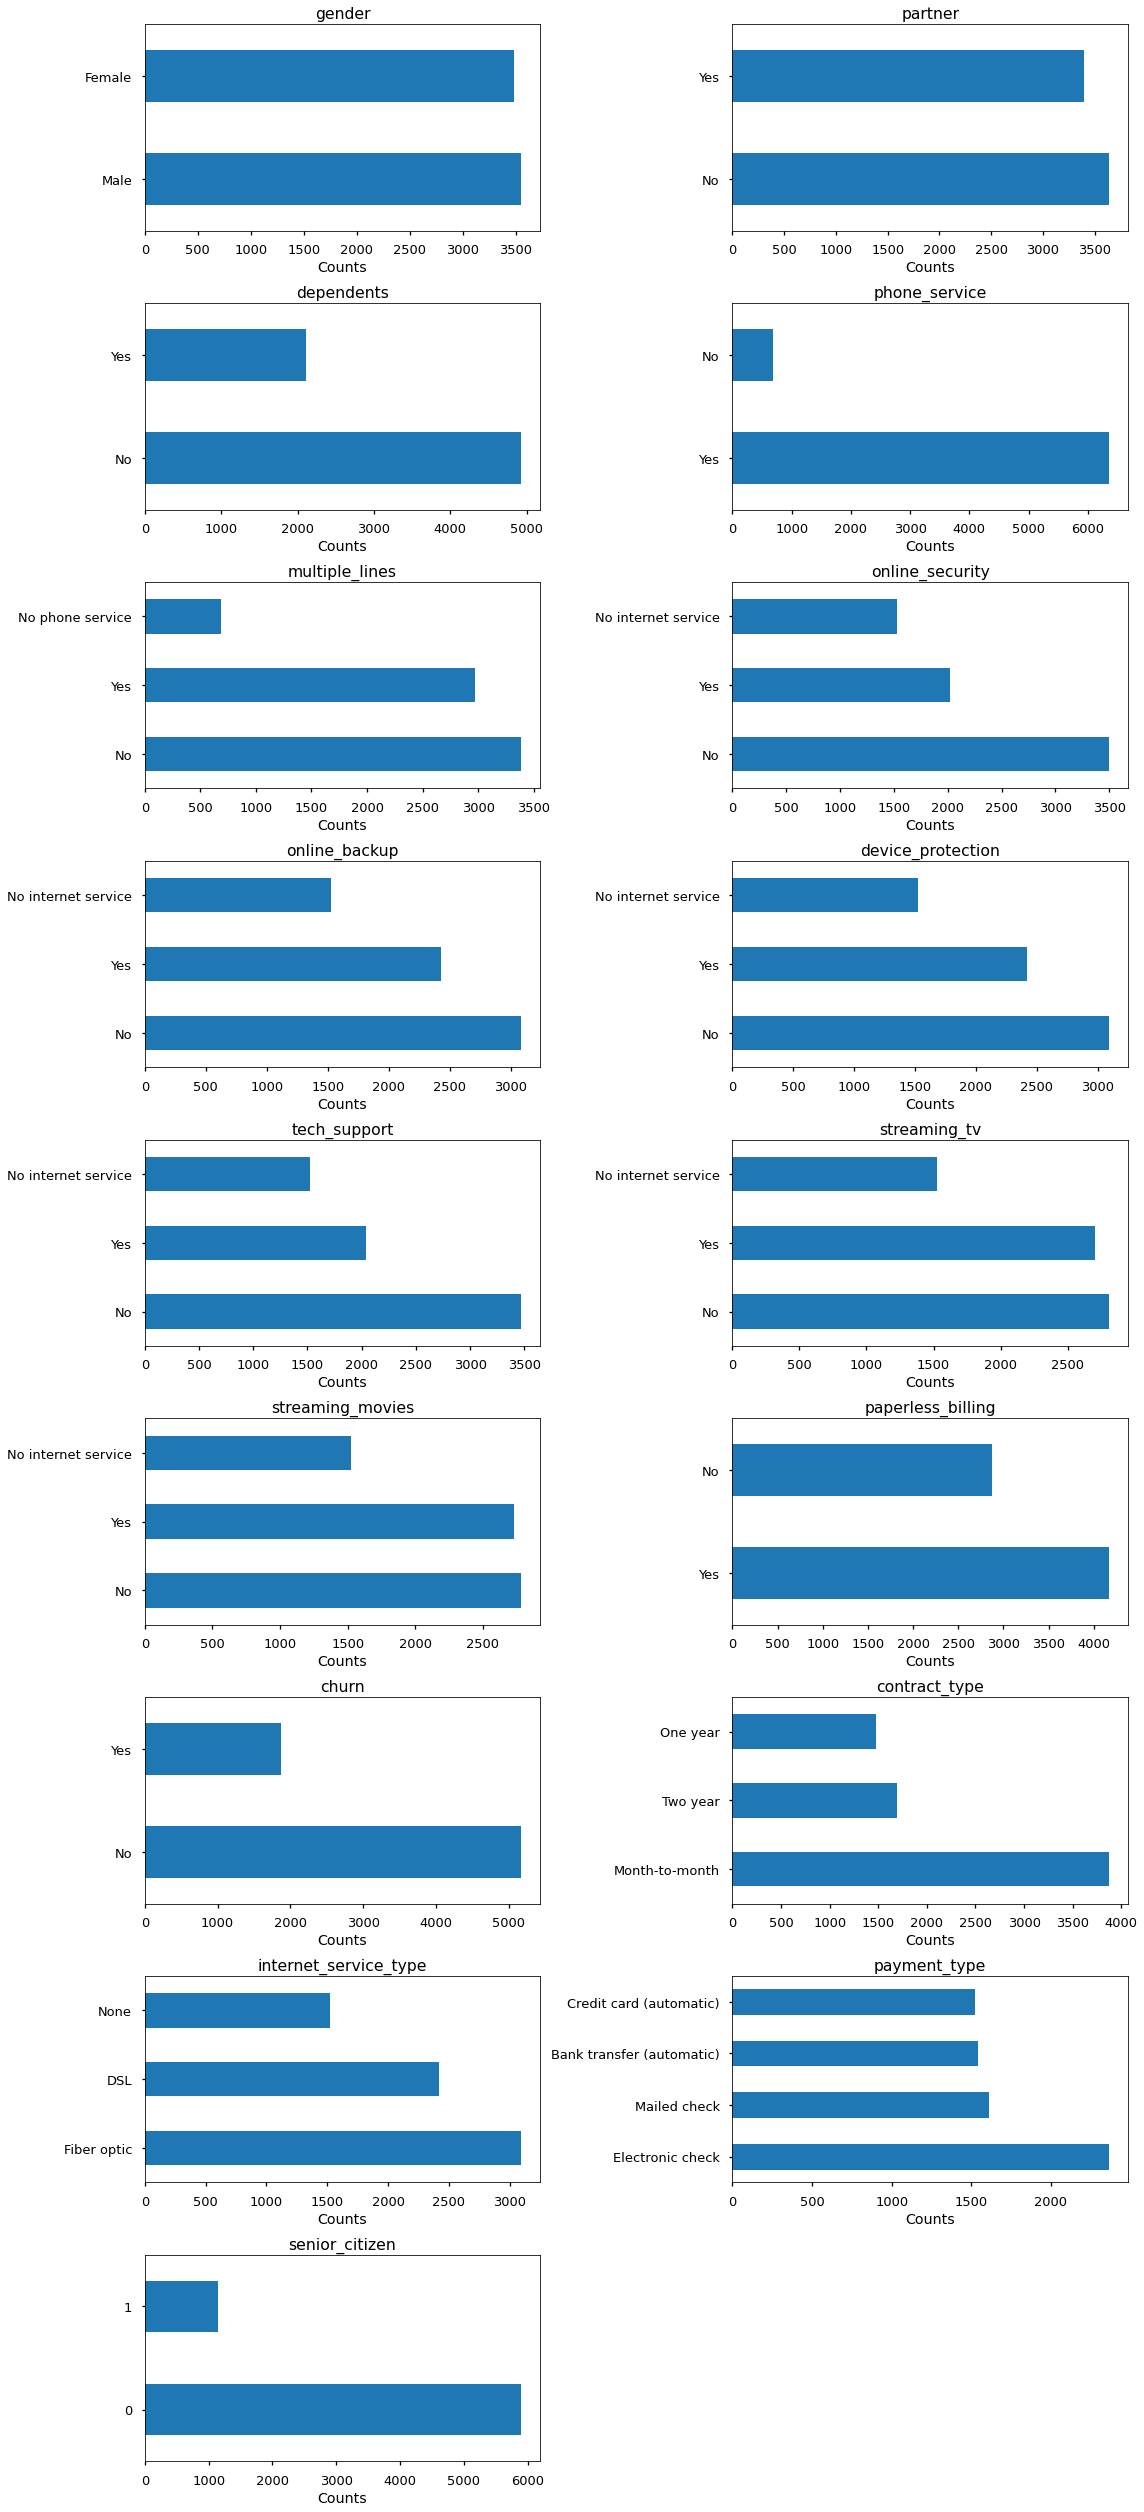

CPU times: user 1.84 s, sys: 99.2 ms, total: 1.94 s
Wall time: 1.59 s


In [13]:
%%time
# Plot the histograms of each object column

plt.figure(figsize=(16,35))

number_cols = len(obj_cols)

for i, variable in zip(range(number_cols), obj_cols):
    plt.subplot(9,2,i+1)
    df[variable].value_counts().plot(kind='barh', title=f'{variable}')
    plt.xlabel('Counts')
    
plt.tight_layout()
plt.show()

In [14]:
# Obtain the name of the non-object columns

mask = (df.dtypes != 'object')
num_cols = variables[mask].to_list()

# Manually correct the list

num_cols.remove('payment_type_id')
num_cols.remove('internet_service_type_id')
num_cols.remove('contract_type_id')
num_cols.remove('senior_citizen')

print(len(num_cols))
num_cols

3


['tenure', 'monthly_charges', 'total_charges']

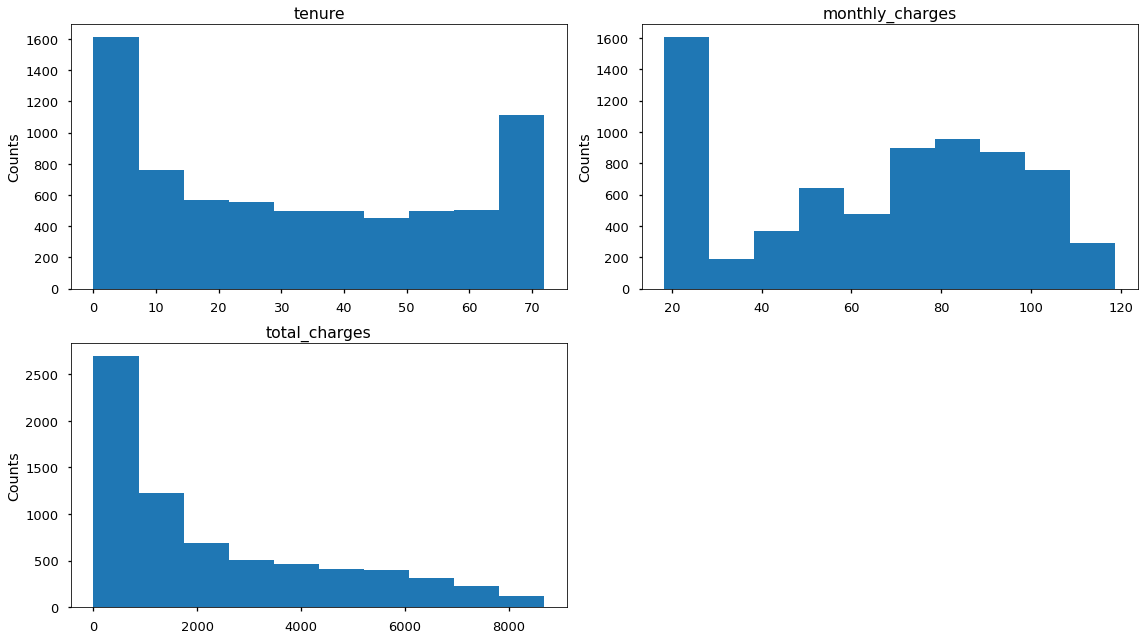

CPU times: user 696 ms, sys: 70.7 ms, total: 767 ms
Wall time: 388 ms


In [15]:
%%time
# Plot the histograms of each numeric column

plt.figure(figsize=(16,9))

number_cols = len(num_cols)

for i, variable in zip(range(number_cols), num_cols):
    plt.subplot(2,2,i+1)
    df[variable].plot(kind='hist', title=f'{variable}')
    plt.ylabel("Counts")
    
plt.tight_layout()
plt.show()

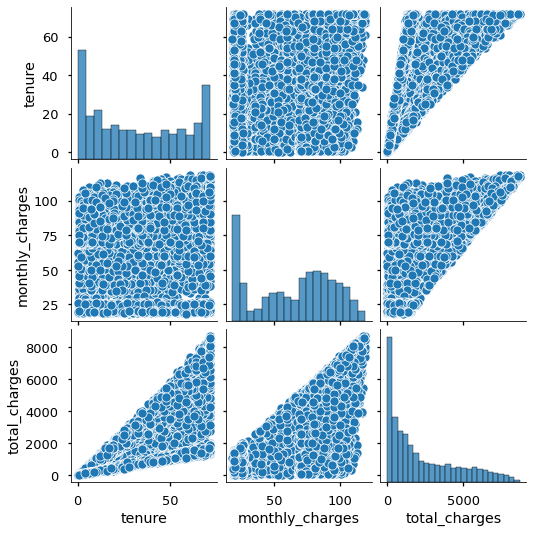

In [16]:
# Pairplot the numeric variables

sns.pairplot(df[num_cols])
plt.show()

### Data Preparation

* Address missing data

* Merge variables with similarit

* Encode variable as needed

* Drop object columns

* Split data into train/validate/test

In [17]:
%%time
# Prepare the data for exploration and modeling

train, validate, test = prepare.prep_telco_churn(df)
train.head()

CPU times: user 42.6 ms, sys: 4.22 ms, total: 46.8 ms
Wall time: 47.6 ms


,customer_id,senior_citizen,tenure,phone_service,device_protection,tech_support,paperless_billing,monthly_charges,total_charges,churn,contract_type,internet_service,payment_type,partner_dependent,streaming,online_service,tenure_year,male
5670,2739-CCZMB,0,5,1,0,0,0,20.35,122.00,0,0,0,1,1,0,0,0.4,1
4152,8035-PWSEV,0,6,1,1,1,1,89.25,487.05,0,0,1,0,0,1,0,0.5,0
4890,6250-CGGUN,0,54,1,1,1,0,84.40,4484.05,0,1,1,0,0,0,1,4.5,1
2391,9499-XPZXM,0,72,1,0,1,0,64.75,4804.75,0,2,1,1,1,0,1,6.0,0
2896,2305-MRGLV,0,28,1,0,1,0,76.55,2065.40,0,0,1,1,1,0,0,2.3,1


In [18]:
# Print a concise summary of train dataset

train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3943 entries, 5670 to 6867
Data columns (total 18 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   customer_id        3943 non-null   object 
 1   senior_citizen     3943 non-null   int64  
 2   tenure             3943 non-null   int64  
 3   phone_service      3943 non-null   int64  
 4   device_protection  3943 non-null   int64  
 5   tech_support       3943 non-null   int64  
 6   paperless_billing  3943 non-null   int64  
 7   monthly_charges    3943 non-null   float64
 8   total_charges      3943 non-null   float64
 9   churn              3943 non-null   int64  
 10  contract_type      3943 non-null   int64  
 11  internet_service   3943 non-null   int64  
 12  payment_type       3943 non-null   int64  
 13  partner_dependent  3943 non-null   int64  
 14  streaming          3943 non-null   int64  
 15  online_service     3943 non-null   int64  
 16  tenure_year        39

In [19]:
# Print the shapes of the train, validate and test

train.shape, validate.shape, test.shape

((3943, 18), (1691, 18), (1409, 18))

### Data Exploration
* Explore target variable:
    * What is the overall churn rate?
* The categorical variables can be grouped into four categories
    * Demographic: senior_citizen, parnter_dependent and Male
    * Services: multiple_lines, device_protection, tech_support, internet_service_type, streaming, and online_service
    * Payment methods: paperless_billing and payment_type
    * Contract: contract_type
* Explore `churn`'s interaction with the numeric variables
    * tenure
    * monthly_tenure
    * total_charges
* Test hypothesis

### What is the overall churn rate? 

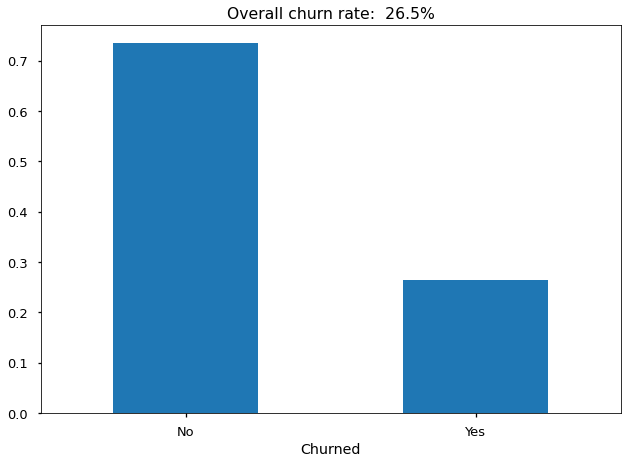

In [25]:
# Compute and visualize the overall churn rate

train.churn.value_counts(normalize=True).plot.bar()
churn_rate = train.churn.mean()
plt.title(f"Overall churn rate: {churn_rate: .1%}")
plt.xlabel('Churned')
plt.xticks([0,1], ['No', 'Yes'], rotation=0) # Set text labels and properties
plt.show()

### Is customer churn independent or dpendent on each categorical features?
$H_0$: Churn is independent of the categorical feature.<br>

$H_a$: Churn is dependent on the categorical feature.<br>

Set $\alpha$=0.05

In [41]:
# Create a list of all categorical features
categorical_vars = ['senior_citizen', 'phone_service', 'device_protection',
                    'tech_support', 'paperless_billing', 'contract_type',
                    'internet_service', 'payment_type', 'partner_dependent', 
                    'streaming', 'online_service', 'male']

# For Loop through the list and perform the hypothesis test
for feature in categorical_vars:
    
    # Compute the contingency(frequency) table
    contingency_table = pd.crosstab(train.churn, train[feature])

    # Print the contingency table
#     print(contingency_table, '\n')

    # Perform chi2 test
    chi2, p, degf, expected = stats.chi2_contingency(contingency_table)

    # Decide whether to reject/accept null hypothesis
    if p/2 < 0.25:
#         print(f'Reject Null Hypotheis, because {p/2: .2} < 0.25')
        print(f"Customer churn is dependent on {feature} feature.")
    elif p/2 > 0.25:
#         print(f'Accept Null Hypotheis, because {p/2: .2} > 0.25')
        print(f"Customer churn is independent of {feature} feature.")

Customer churn is dependent on senior_citizen feature.
Customer churn is independent of phone_service feature.
Customer churn is dependent on device_protection feature.
Customer churn is dependent on tech_support feature.
Customer churn is dependent on paperless_billing feature.
Customer churn is dependent on contract_type feature.
Customer churn is dependent on internet_service feature.
Customer churn is dependent on payment_type feature.
Customer churn is dependent on partner_dependent feature.
Customer churn is dependent on streaming feature.
Customer churn is dependent on online_service feature.
Customer churn is independent of male feature.


**Takeaways**
- Churn is dependent on whether or not a customer is senior.

**Key Concepts Explained**
* A contingency table displays the multivariate frequency distribution of the variables.
* A frequency distribution displays the frequency of various outcomes in a sample.
* chi-squared test applies to sets of categorical variables to evaluate how likely it is that any observed difference between the sets arose by chance.
* The way the chi2 test works is to compare the actural contingency table against the table we would predict to be the case if group membership is independent.
* `chi2_contingency` function returns four values:
    * chi2 test statistic
    * p value
    * degrees of freedom
    * the matrix (nparray) of expected values

<AxesSubplot:xlabel='churn', ylabel='monthly_charges'>

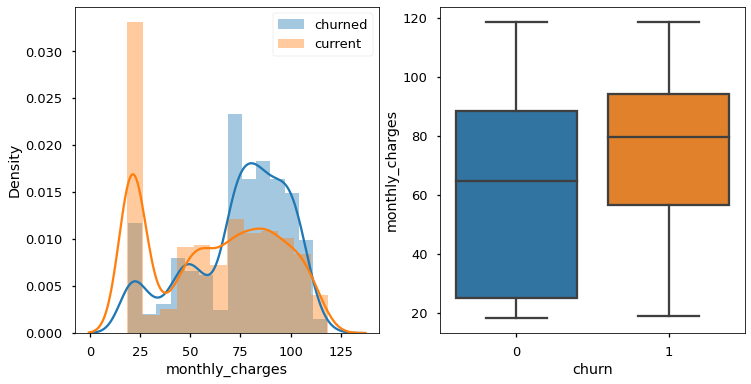

In [50]:
boolean_churned = train.churn == 1
boolean_current = train.churn == 0

monthly_charges_churned = train[boolean_churned].monthly_charges
monthly_charges_current = train[boolean_current].monthly_charges

plt.figure(figsize=(12,6))
plt.subplot(121)

sns.distplot(monthly_charges_churned, label='churned')
sns.distplot(monthly_charges_current, label='current')
plt.legend()

plt.subplot(122)

sns.boxplot(data=train, x='churn', y='monthly_charges')

<AxesSubplot:xlabel='churn', ylabel='tenure'>

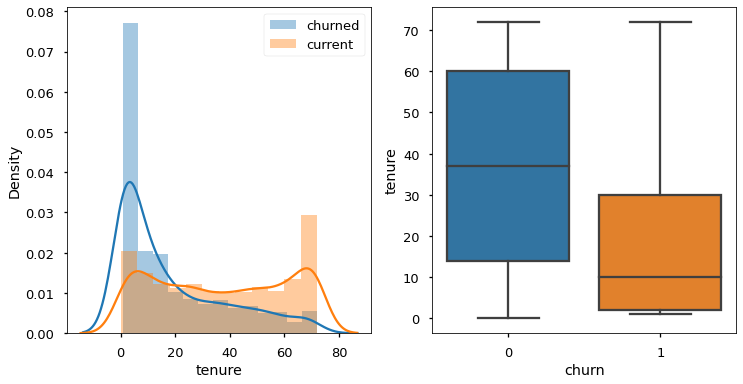

In [51]:
plt.figure(figsize=(12,6))

tenure_churned = train[boolean_churned].tenure
tenure_current = train[boolean_current].tenure

plt.subplot(121)

sns.distplot(tenure_churned, label='churned')
sns.distplot(tenure_current, label='current')
plt.legend()

plt.subplot(122)

sns.boxplot(data=train, x='churn', y='tenure')

### Is there a difference in monthly charges between the churned and the current? 
$H_0$: The monthly bill of churned customers is no difference than that of customers still in business.<br>
$H_a$: The monthly bill of churned customers is significantly higher than that of customers still in business.<br>
$\alpha$=0.05

In [ ]:
train[boolean_churned].monthly_charges.var(), train[boolean_current].monthly_charges.var()

In [ ]:
t, p = stats.ttest_ind(monthly_charges_churned, monthly_charges_current, equal_var=False)
t, p

In [ ]:
if t > 0 and p < 0.5:
    print('Reject Null Hypotheis')
else:
    print('Accept Null Hypotheis')

### Is there a difference in tenure between the churned and the current? 
$H_0$: There is no difference in tenure between the churned and the current.<br>
$H_a$: There is sigficantly difference in tenure between the churned and the current. <br>
$\alpha$=0.05

In [ ]:
train[boolean_churned].tenure.var(), train[boolean_current].tenure.var()

In [ ]:
t, p = stats.ttest_ind(tenure_churned, tenure_current, equal_var=False)
t, p

In [ ]:
if t > 0 and p < 0.5:
    print('Reject Null Hypotheis')
else:
    print('Accept Null Hypotheis')

**14 Features has significant impact**
- male
- senior_citizen
- partner_dependent
- phone_service
- internect_service
- streaming
- online_service
- device_protection
- tech_support
- paperless_billing
- payment_type
- contract_type
- tenure
- monthly_charge

Then I took the coefficients from logistic regression and rank them by the absolute value of coefficients

**Biggest 5**
- contract_type
- internet_service
- online_service
- tech_support
- senior_citizen




## Modeling and Evaluation
### Baseline Accuracy: 0.734

In [36]:
train.churn.value_counts(normalize=True)

0    0.73472
1    0.26528
Name: churn, dtype: float64

### Model 1: Logistic Regression
* X
* y

In [37]:
train.head()

,customer_id,senior_citizen,tenure,phone_service,device_protection,tech_support,paperless_billing,monthly_charges,total_charges,churn,contract_type,internet_service,payment_type,partner_dependent,streaming,online_service,tenure_year,male
5670,2739-CCZMB,0,5,1,0,0,0,20.35,122,0,0,0,1,1,0,0,0.4,1
4152,8035-PWSEV,0,6,1,1,1,1,89.25,487.05,0,0,1,0,0,1,0,0.5,0
4890,6250-CGGUN,0,54,1,1,1,0,84.40,4484.05,0,1,1,0,0,0,1,4.5,1
2391,9499-XPZXM,0,72,1,0,1,0,64.75,4804.75,0,2,1,1,1,0,1,6.0,0
2896,2305-MRGLV,0,28,1,0,1,0,76.55,2065.4,0,0,1,1,1,0,0,2.3,1


In [38]:
X_train = train.drop(columns=['customer_id','churn','male','phone_service','total_charges','tenure_year'])
y_train = train['churn']

X_train.head()

,senior_citizen,tenure,device_protection,tech_support,paperless_billing,monthly_charges,contract_type,internet_service,payment_type,partner_dependent,streaming,online_service
5670,0,5,0,0,0,20.35,0,0,1,1,0,0
4152,0,6,1,1,1,89.25,0,1,0,0,1,0
4890,0,54,1,1,0,84.40,1,1,0,0,0,1
2391,0,72,0,1,0,64.75,2,1,1,1,0,1
2896,0,28,0,1,0,76.55,0,1,1,1,0,0


In [39]:
y_train[:5]

5670    0
4152    0
4890    0
2391    0
2896    0
Name: churn, dtype: int64

In [40]:
X_train.shape, y_train.shape

((3943, 12), (3943,))

In [41]:
# Create the logistic regression object

logit = LogisticRegression(C=1, random_state=123)

# Fit the model to the training data

logit.fit(X_train, y_train)

# Print the coefficients and intercept of the model

print('Coefficient: \n', logit.coef_)
print('Intercept: \n', logit.intercept_)

Coefficient: 
 [[ 0.17813011 -0.02964689 -0.07129607 -0.58495958  0.41441983  0.02425137
  -0.72737203  0.61091992 -0.2298884  -0.11678185 -0.02720378 -0.35899057]]
Intercept: 
 [-1.91462893]


In [42]:
# Rank features by the absolute values of their coefficient

coefficient = logit.coef_
coefficient = pd.DataFrame(coefficient).T
coefficient['features'] = X_train.columns.tolist()
coefficient['coeffcient_abs'] = coefficient[0].abs()
coefficient.sort_values(by='coeffcient_abs', ascending=False)

,0,features,coeffcient_abs
6,-0.727372,contract_type,0.727372
7,0.610920,internet_service,0.610920
3,-0.584960,tech_support,0.584960
4,0.414420,paperless_billing,0.414420
11,-0.358991,online_service,0.358991
8,-0.229888,payment_type,0.229888
0,0.178130,senior_citizen,0.178130
9,-0.116782,partner_dependent,0.116782
2,-0.071296,device_protection,0.071296
1,-0.029647,tenure,0.029647


In [43]:
y_pred = logit.predict(X_train)
y_pred

y_pred_proba = logit.predict_proba(X_train)

# Compute the accuracy

print(logit.score(X_train, y_train))

# Create a confusion matrix

print(confusion_matrix(y_train, y_pred))

# Compute Precision, Recall, F1-score, and Support

print(classification_report(y_train, y_pred))

0.7968551864062896
[[2612  285]
 [ 516  530]]
              precision    recall  f1-score   support

           0       0.84      0.90      0.87      2897
           1       0.65      0.51      0.57      1046

    accuracy                           0.80      3943
   macro avg       0.74      0.70      0.72      3943
weighted avg       0.79      0.80      0.79      3943



### Model 2: Decision Tree

In [44]:
clf = DecisionTreeClassifier(max_depth=3, random_state=123)

clf.fit(X_train, y_train)

y_pred = clf.predict(X_train)
y_pred

y_pred_proba = clf.predict_proba(X_train)

# Compute the accuracy

print(clf.score(X_train, y_train))

# Create a confusion matrix

print(confusion_matrix(y_train, y_pred))

# Compute Precision, Recall, F1-score, and Support

print(classification_report(y_train, y_pred))

0.7862033984275932
[[2699  198]
 [ 645  401]]
              precision    recall  f1-score   support

           0       0.81      0.93      0.86      2897
           1       0.67      0.38      0.49      1046

    accuracy                           0.79      3943
   macro avg       0.74      0.66      0.68      3943
weighted avg       0.77      0.79      0.76      3943



### Model 3: Random Forest

In [ ]:
rf = RandomForestClassifier(n_estimators=100, 
                            max_depth=3, 
                            min_samples_split=2, 
                            min_samples_leaf=5, 
                            random_state=123)

rf.fit(X_train, y_train)

y_pred = rf.predict(X_train)
y_pred

y_pred_proba = rf.predict_proba(X_train)

# Compute the accuracy

print(rf.score(X_train, y_train))

# Create a confusion matrix

print(confusion_matrix(y_train, y_pred))

# Compute Precision, Recall, F1-score, and Support

print(classification_report(y_train, y_pred))

### Model 4: KNN

In [45]:
knn = KNeighborsClassifier(n_neighbors=5, weights='uniform')

knn.fit(X_train, y_train)

y_pred = knn.predict(X_train)
y_pred

y_pred_proba = knn.predict_proba(X_train)

# Compute the accuracy

print(knn.score(X_train, y_train))

# Create a confusion matrix

print(confusion_matrix(y_train, y_pred))

# Compute Precision, Recall, F1-score, and Support

print(classification_report(y_train, y_pred))

0.8392087243215826
[[2667  230]
 [ 404  642]]
              precision    recall  f1-score   support

           0       0.87      0.92      0.89      2897
           1       0.74      0.61      0.67      1046

    accuracy                           0.84      3943
   macro avg       0.80      0.77      0.78      3943
weighted avg       0.83      0.84      0.83      3943



### Validate
* KNN
* LR
* CLF

In [46]:
X_validate = validate.drop(columns=['customer_id', 'churn','male',
                                    'phone_service','total_charges','tenure_year'])
y_validate = validate['churn']

X_validate.head()

,senior_citizen,tenure,device_protection,tech_support,paperless_billing,monthly_charges,contract_type,internet_service,payment_type,partner_dependent,streaming,online_service
611,0,7,1,0,0,48.70,0,1,0,1,0,0
4449,0,3,0,0,1,69.55,0,1,1,0,0,0
4871,0,50,1,0,1,104.40,1,1,0,1,1,1
5889,0,8,0,0,0,19.20,0,0,0,0,0,0
432,0,2,0,0,1,53.85,0,1,0,0,0,1


In [47]:
X_validate.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1691 entries, 611 to 3430
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   senior_citizen     1691 non-null   int64  
 1   tenure             1691 non-null   int64  
 2   device_protection  1691 non-null   int64  
 3   tech_support       1691 non-null   int64  
 4   paperless_billing  1691 non-null   int64  
 5   monthly_charges    1691 non-null   float64
 6   contract_type      1691 non-null   int64  
 7   internet_service   1691 non-null   int64  
 8   payment_type       1691 non-null   int64  
 9   partner_dependent  1691 non-null   int64  
 10  streaming          1691 non-null   int64  
 11  online_service     1691 non-null   int64  
dtypes: float64(1), int64(11)
memory usage: 171.7 KB


In [48]:
y_pred = knn.predict(X_validate)
y_pred

y_pred_proba = knn.predict_proba(X_validate)

# Compute the accuracy

print(knn.score(X_validate, y_validate))

# Create a confusion matrix

print(confusion_matrix(y_validate, y_pred))

# Compute Precision, Recall, F1-score, and Support

print(classification_report(y_validate, y_pred))

0.7616794795978711
[[1079  163]
 [ 240  209]]
              precision    recall  f1-score   support

           0       0.82      0.87      0.84      1242
           1       0.56      0.47      0.51       449

    accuracy                           0.76      1691
   macro avg       0.69      0.67      0.68      1691
weighted avg       0.75      0.76      0.75      1691



In [49]:
y_pred = logit.predict(X_validate)
y_pred

y_pred_proba = logit.predict_proba(X_validate)

# Compute the accuracy

print(logit.score(X_validate, y_validate))

# Create a confusion matrix

print(confusion_matrix(y_validate, y_pred))

# Compute Precision, Recall, F1-score, and Support

print(classification_report(y_validate, y_pred))

0.8089887640449438
[[1127  115]
 [ 208  241]]
              precision    recall  f1-score   support

           0       0.84      0.91      0.87      1242
           1       0.68      0.54      0.60       449

    accuracy                           0.81      1691
   macro avg       0.76      0.72      0.74      1691
weighted avg       0.80      0.81      0.80      1691



In [50]:
y_pred = clf.predict(X_validate)
y_pred

y_pred_proba = clf.predict_proba(X_validate)

# Compute the accuracy

print(clf.score(X_validate, y_validate))

# Create a confusion matrix

print(confusion_matrix(y_validate, y_pred))

# Compute Precision, Recall, F1-score, and Support

print(classification_report(y_validate, y_pred))

0.7876995860437611
[[1173   69]
 [ 290  159]]
              precision    recall  f1-score   support

           0       0.80      0.94      0.87      1242
           1       0.70      0.35      0.47       449

    accuracy                           0.79      1691
   macro avg       0.75      0.65      0.67      1691
weighted avg       0.77      0.79      0.76      1691



### Test using best model

In [51]:
X_test = test.drop(columns=['customer_id','churn','male','phone_service','total_charges','tenure_year'])
y_test = test['churn']

X_test.head()

,senior_citizen,tenure,device_protection,tech_support,paperless_billing,monthly_charges,contract_type,internet_service,payment_type,partner_dependent,streaming,online_service
3160,0,2,0,0,0,79.55,0,1,0,0,0,1
1592,0,23,0,1,1,57.75,1,1,0,1,0,1
5824,0,15,0,0,0,19.75,0,0,1,0,0,0
3866,1,14,0,0,0,78.85,0,1,0,0,0,1
714,0,3,0,0,0,35.20,0,1,1,0,1,0


In [52]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1409 entries, 3160 to 779
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   senior_citizen     1409 non-null   int64  
 1   tenure             1409 non-null   int64  
 2   device_protection  1409 non-null   int64  
 3   tech_support       1409 non-null   int64  
 4   paperless_billing  1409 non-null   int64  
 5   monthly_charges    1409 non-null   float64
 6   contract_type      1409 non-null   int64  
 7   internet_service   1409 non-null   int64  
 8   payment_type       1409 non-null   int64  
 9   partner_dependent  1409 non-null   int64  
 10  streaming          1409 non-null   int64  
 11  online_service     1409 non-null   int64  
dtypes: float64(1), int64(11)
memory usage: 143.1 KB


In [53]:
y_pred = knn.predict(X_test)
y_pred

y_pred_proba = knn.predict_proba(X_test)

# Compute the accuracy

print(knn.score(X_test, y_test))

# Create a confusion matrix

print(confusion_matrix(y_test, y_pred))

# Compute Precision, Recall, F1-score, and Support

print(classification_report(y_test, y_pred))

0.7686302342086586
[[897 138]
 [188 186]]
              precision    recall  f1-score   support

           0       0.83      0.87      0.85      1035
           1       0.57      0.50      0.53       374

    accuracy                           0.77      1409
   macro avg       0.70      0.68      0.69      1409
weighted avg       0.76      0.77      0.76      1409



### predictions.csv
* csv file with customer_id, probability of churn, and prediction of churn (1=churn, 0=not_churn)

In [55]:
# load original data in form of pandas data frame. 

df = acquire.get_telco_churn_data()
df.head()

,payment_type_id,internet_service_type_id,contract_type_id,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,...,tech_support,streaming_tv,streaming_movies,paperless_billing,monthly_charges,total_charges,churn,contract_type,internet_service_type,payment_type
0,2,1,1,0003-MKNFE,Male,0,No,No,9,Yes,...,No,No,Yes,No,59.9,542.4,No,Month-to-month,DSL,Mailed check
1,4,1,1,0013-MHZWF,Female,0,No,Yes,9,Yes,...,Yes,Yes,Yes,Yes,69.4,571.45,No,Month-to-month,DSL,Credit card (automatic)
2,1,1,1,0015-UOCOJ,Female,1,No,No,7,Yes,...,No,No,No,Yes,48.2,340.35,No,Month-to-month,DSL,Electronic check
3,1,1,1,0023-HGHWL,Male,1,No,No,1,No,...,No,No,No,Yes,25.1,25.1,Yes,Month-to-month,DSL,Electronic check
4,3,1,1,0032-PGELS,Female,0,Yes,Yes,1,No,...,No,No,No,No,30.5,30.5,Yes,Month-to-month,DSL,Bank transfer (automatic)


In [56]:
# clean the df but no splitting

df_cleaned = prepare.cleaning(df)
df_cleaned.head()

,customer_id,senior_citizen,tenure,phone_service,device_protection,tech_support,paperless_billing,monthly_charges,total_charges,churn,contract_type,internet_service,payment_type,partner_dependent,streaming,online_service,tenure_year,male
0,0003-MKNFE,0,9,1,0,0,0,59.9,542.4,0,0,1,0,0,1,0,0.8,1
1,0013-MHZWF,0,9,1,0,1,1,69.4,571.45,0,0,1,1,1,1,0,0.8,0
2,0015-UOCOJ,1,7,1,0,0,1,48.2,340.35,0,0,1,0,0,0,1,0.6,0
3,0023-HGHWL,1,1,0,0,0,1,25.1,25.1,1,0,1,0,0,0,0,0.1,1
4,0032-PGELS,0,1,0,0,0,0,30.5,30.5,1,0,1,1,1,0,1,0.1,0


In [59]:
# create X and y for the entire df

X = df_cleaned.drop(columns=['customer_id','churn','male','phone_service','total_charges','tenure_year'])
y =df_cleaned['churn']

X.shape, y.shape

((7043, 12), (7043,))

In [60]:
X.head()

,senior_citizen,tenure,device_protection,tech_support,paperless_billing,monthly_charges,contract_type,internet_service,payment_type,partner_dependent,streaming,online_service
0,0,9,0,0,0,59.9,0,1,0,0,1,0
1,0,9,0,1,1,69.4,0,1,1,1,1,0
2,1,7,0,0,1,48.2,0,1,0,0,0,1
3,1,1,0,0,1,25.1,0,1,0,0,0,0
4,0,1,0,0,0,30.5,0,1,1,1,0,1


In [61]:
# Fit the best model to X and y

y_pred = knn.predict(X)
y_pred

y_pred_proba = knn.predict_proba(X)

# Compute the accuracy

print(knn.score(X, y))

# Create a confusion matrix

print(confusion_matrix(y, y_pred))

# Compute Precision, Recall, F1-score, and Support

print(classification_report(y, y_pred))

0.8064745137015477
[[4643  531]
 [ 832 1037]]
              precision    recall  f1-score   support

           0       0.85      0.90      0.87      5174
           1       0.66      0.55      0.60      1869

    accuracy                           0.81      7043
   macro avg       0.75      0.73      0.74      7043
weighted avg       0.80      0.81      0.80      7043



In [62]:
# Create data frame contain customer_id only
df_predict = df[['customer_id']]

# Create the series holding probability of churn
P_churn = [i[1] for i in y_pred_proba]

# Add columns probability of churn and prediction of churn
df_predict['probability_of_churn'] = P_churn
df_predict['prediction_of_churn'] = y_pred

In [63]:
df_predict.sample(10)

,customer_id,probability_of_churn,prediction_of_churn
4185,8182-BJDSI,0.6,1
2686,1262-OPMFY,0.2,0
1349,2321-OMBXY,0.4,0
4231,8468-EHYJA,0.2,0
4288,8761-NSOBC,0.8,1
7016,9574-BOSMD,0.0,0
942,7675-OZCZG,0.4,0
2170,6248-TKCQV,0.0,0
5285,4829-ZLJTK,0.0,0
1465,4342-HFXWS,0.0,0


In [ ]:
df_predict.to_csv('prediction.csv')

### Conclusions

* The biggest 5 drivers for customer churn are contract_type, internet_service, online_service, tech_support, senior_citizen.

* With accuracy of 82.8%, K-Nearest Neighbor are the top model after initial exploration. 

* Deliverables are successfully produced for the purpose of reproduction and further optimization. 

### Next Steps

* Explore the reasons behind the most influential factors.

* Optimize the classification model by combination of different features and changing the hyperparameters of the algorithms.

* Explore different encoding strategies for binary categorical variables.